## Data Preparation and Data Cleaning

1. **Reshape the data**: The image data in the CIFAR-100 dataset is stored as 1D arrays. We want to reshape it into 3D arrays (32x32x3) for easier processing and analysis.

2. **Resize the data**: The image data in the CIFAR-100 dataset is 32x32. To be able to use transfer learning using common pretrained models, the image data has to be resized to a minimum of 75x75.

3. **Normalize the data**: The pixel values of the images are in the range [0, 255]. We want to normalize these values to the range [0, 1] for better performance of the machine learning models.

4. **Consider only the coarse labels**: For simplicity, We can consider only the 20 "coarse" labels (superclasses) rather than the 100 "fine" labels (classes) when We train multi-class image classifiers for this dataset. This means We would use `coarse_labels` instead of `fine_labels` in our code.

5. **One-hot encode the labels**: The labels are currently integers representing the class of each image. We want to one-hot encode these labels for multi-class classification tasks.

6. **Split the data**: The CIFAR-100 dataset comes with predefined train and test sets. We want to further split the train set into a validation set for tuning the hyperparameters of our models.

In [2]:
import numpy as np
import os
import pickle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

# Load the data
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Downsample the data
def downsample_data(data, labels, num_samples_per_class):
    downsampled_data = []
    downsampled_labels = []
    for i in range(20):  # 20 superclasses
        indices = np.where(labels == i)[0]
        downsampled_indices = np.random.choice(indices, num_samples_per_class, replace=False)
        downsampled_data.append(data[downsampled_indices])
        downsampled_labels.append(labels[downsampled_indices])
    return np.concatenate(downsampled_data), np.concatenate(downsampled_labels)

# Load the data
metadata_path = '../data/cifar-100-python/meta'
metadata = unpickle(metadata_path)
data_train_path = '../data/cifar-100-python/train'
data_test_path = '../data/cifar-100-python/test'
data_train_dict = unpickle(data_train_path)
data_test_dict = unpickle(data_test_path)

# Downsample the data
data_train, label_train = downsample_data(data_train_dict[b'data'], np.array(data_train_dict[b'coarse_labels']), 500)
data_test, label_test = downsample_data(data_test_dict[b'data'], np.array(data_test_dict[b'coarse_labels']), 100)

# Reshape the data
data_train = data_train.reshape((data_train.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)
data_test = data_test.reshape((data_test.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)

# Resize the data to (75, 75)
data_train = tf.image.resize(data_train, [75, 75])
data_test = tf.image.resize(data_test, [75, 75])

# Normalize the data
data_train = data_train.numpy().astype('float32') / 255
data_test = data_test.numpy().astype('float32') / 255

# One-hot encode the labels
label_train = to_categorical(label_train, 20)
label_test = to_categorical(label_test, 20)

# Split the data into train and validate sets
data_train, data_validate, label_train, label_validate = train_test_split(data_train, label_train, test_size=0.2, random_state=42)

# Save the cleaned and processed data
os.makedirs('../data/clean-all-cifar-100-python/train', exist_ok=True)
os.makedirs('../data/clean-all-cifar-100-python/validate', exist_ok=True)
os.makedirs('../data/clean-all-cifar-100-python/test', exist_ok=True)
np.save('../data/clean-all-cifar-100-python/train/data.npy', data_train)
np.save('../data/clean-all-cifar-100-python/train/labels.npy', label_train)
np.save('../data/clean-all-cifar-100-python/validate/data.npy', data_validate)
np.save('../data/clean-all-cifar-100-python/validate/labels.npy', label_validate)
np.save('../data/clean-all-cifar-100-python/test/data.npy', data_test)
np.save('../data/clean-all-cifar-100-python/test/labels.npy', label_test)

2023-12-13 11:44:55.799917: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-13 11:45:02.396004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-13 11:45:02.402003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-13 11:45:02.402590: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-13 11:45:02.403512: I tensorflow/core/

## EDA (Exploratory Data Analysis), Feature Importance Analysis

1. **Visualize the images**: Display some sample images from each class to get a sense of what the images look like.

2. **Class distribution**: Check the distribution of the classes in the train and test sets. If the classes are imbalanced, We need to take this into account when training our models.

3. **Feature importance**: In the context of image data, feature importance analysis might involve using techniques like occlusion sensitivity to understand which parts of the images are most important for the predictions of a trained model.

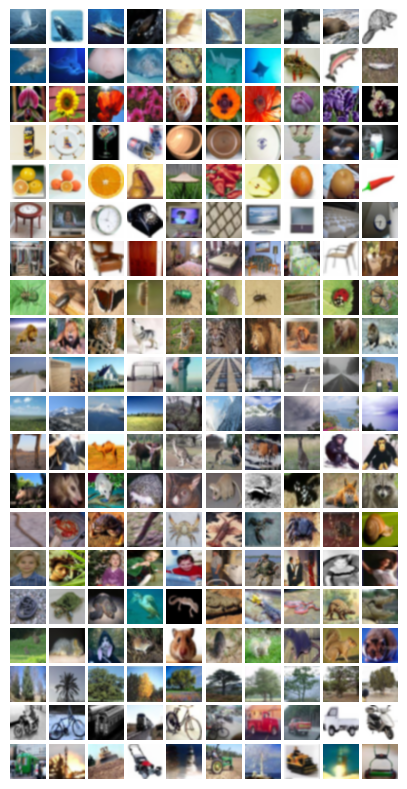

Class distribution: [395. 397. 394. 404. 398. 410. 380. 419. 401. 390. 412. 402. 388. 401.
 405. 391. 396. 392. 411. 414.]
Class distribution: [100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100.]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the data
def load_data(folder):
    data = np.load(os.path.join(folder, 'data.npy'))
    labels = np.load(os.path.join(folder, 'labels.npy'))
    return data, labels

# Visualize the images
def visualize_images(data, labels, num_images_per_class):
    fig, axs = plt.subplots(20, num_images_per_class, figsize=(5, 10))  # 20 superclasses
    for i in range(20):  # For each superclass
        indices = np.where(np.argmax(labels, axis=1) == i)[0]
        random_indices = np.random.choice(indices, num_images_per_class, replace=False)
        for j, image_index in enumerate(random_indices):
            image = data[image_index]
            axs[i, j].imshow(image, interpolation='bicubic')
            axs[i, j].axis('off')  # Hide axes
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

# Check the class distribution
def check_class_distribution(labels):
    class_distribution = np.sum(labels, axis=0)
    print("Class distribution:", class_distribution)

# Load the data
data_train, label_train = load_data('../data/clean-all-cifar-100-python/train')
data_test, label_test = load_data('../data/clean-all-cifar-100-python/test')

# Visualize the images
visualize_images(data_train, label_train, 10)

# Check the class distribution
check_class_distribution(label_train)
check_class_distribution(label_test)

## Model Selection Process and Parameter Tuning

1. **Choose a model architecture**: For image classification tasks, convolutional neural networks (CNNs) are usually a good choice. We want to experiment with three different architectures (Xception, ResNet50, DenseNet121) to see which one works best for this dataset.

2. **Hyperparameter tuning**: Tune the hyperparameters of our model (learning rate, batch size, number of layers) to optimize its performance.

3. **Regularization**: To prevent overfitting, We want to use regularization techniques like dropout.

4. **Model training**: Train our model using the train set and monitor its performance on the validation set. We can use techniques like early stopping to prevent overfitting.

5. **Model evaluation**: Evaluate the performance of our model on the test set using appropriate metrics (e.g., accuracy, precision, recall, F1 score).

### A) Model Architecture: Xception

0.0001
Epoch 1/10


2023-12-13 11:45:17.898032: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-12-13 11:45:18.544931: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-13 11:45:18.545597: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-13 11:45:18.545633: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-12-13 11:45:18.546603: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-13 11:45:18.546696: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


250/250 [==============================] - 11s 28ms/step - loss: 2.9460 - accuracy: 0.0782 - val_loss: 2.8640 - val_accuracy: 0.0980
Epoch 2/10
250/250 [==============================] - 6s 23ms/step - loss: 2.6965 - accuracy: 0.1856 - val_loss: 2.5841 - val_accuracy: 0.2595
Epoch 3/10
250/250 [==============================] - 6s 23ms/step - loss: 2.4336 - accuracy: 0.3150 - val_loss: 2.3916 - val_accuracy: 0.3270
Epoch 4/10
250/250 [==============================] - 6s 23ms/step - loss: 2.2636 - accuracy: 0.3663 - val_loss: 2.2605 - val_accuracy: 0.3695
Epoch 5/10
250/250 [==============================] - 6s 23ms/step - loss: 2.1386 - accuracy: 0.4106 - val_loss: 2.1633 - val_accuracy: 0.3970
Epoch 6/10
250/250 [==============================] - 6s 23ms/step - loss: 2.0372 - accuracy: 0.4437 - val_loss: 2.0772 - val_accuracy: 0.4280
Epoch 7/10
250/250 [==============================] - 6s 23ms/step - loss: 1.9518 - accuracy: 0.4686 - val_loss: 2.0164 - val_accuracy: 0.4440
Epoch 8/1

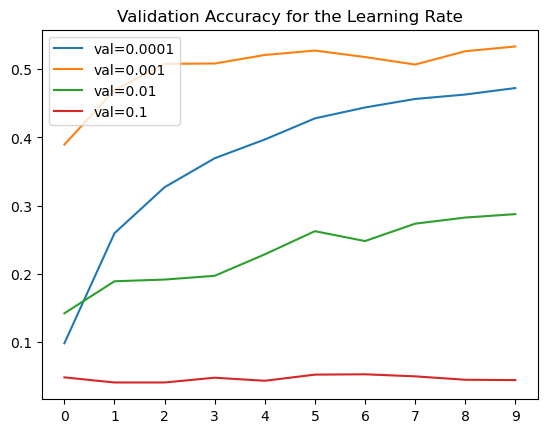

10
Epoch 1/10
250/250 [==============================] - 9s 27ms/step - loss: 2.4732 - accuracy: 0.2556 - val_loss: 2.0642 - val_accuracy: 0.4020
Epoch 2/10
250/250 [==============================] - 6s 24ms/step - loss: 1.8616 - accuracy: 0.4541 - val_loss: 1.8400 - val_accuracy: 0.4565
Epoch 3/10
250/250 [==============================] - 6s 23ms/step - loss: 1.6509 - accuracy: 0.5161 - val_loss: 1.7621 - val_accuracy: 0.4825
Epoch 4/10
250/250 [==============================] - 6s 24ms/step - loss: 1.5373 - accuracy: 0.5441 - val_loss: 1.7243 - val_accuracy: 0.4785
Epoch 5/10
250/250 [==============================] - 6s 23ms/step - loss: 1.4473 - accuracy: 0.5664 - val_loss: 1.7158 - val_accuracy: 0.4805
Epoch 6/10
250/250 [==============================] - 6s 24ms/step - loss: 1.3647 - accuracy: 0.5901 - val_loss: 1.6699 - val_accuracy: 0.5015
Epoch 7/10
250/250 [==============================] - 6s 24ms/step - loss: 1.2852 - accuracy: 0.6141 - val_loss: 1.6551 - val_accuracy: 0.4

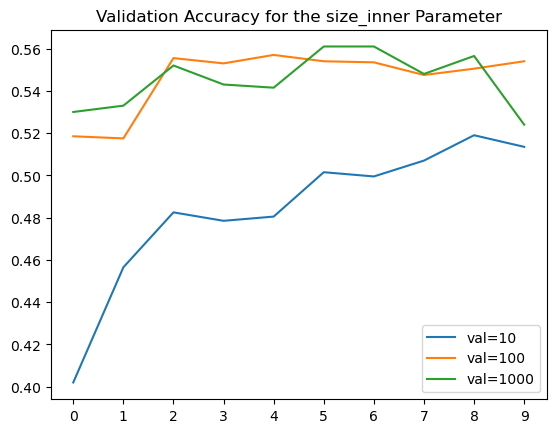

0.0
Epoch 1/10
250/250 [==============================] - 9s 27ms/step - loss: 1.7572 - accuracy: 0.4922 - val_loss: 1.6237 - val_accuracy: 0.5005
Epoch 2/10
250/250 [==============================] - 6s 24ms/step - loss: 1.1548 - accuracy: 0.6442 - val_loss: 1.5246 - val_accuracy: 0.5475
Epoch 3/10
250/250 [==============================] - 6s 24ms/step - loss: 0.8185 - accuracy: 0.7414 - val_loss: 1.5496 - val_accuracy: 0.5590
Epoch 4/10
250/250 [==============================] - 6s 24ms/step - loss: 0.5495 - accuracy: 0.8300 - val_loss: 1.6512 - val_accuracy: 0.5545
Epoch 5/10
250/250 [==============================] - 6s 24ms/step - loss: 0.3434 - accuracy: 0.9006 - val_loss: 1.8390 - val_accuracy: 0.5605
Epoch 6/10
250/250 [==============================] - 6s 24ms/step - loss: 0.2131 - accuracy: 0.9473 - val_loss: 1.9895 - val_accuracy: 0.5545
Epoch 7/10
250/250 [==============================] - 6s 24ms/step - loss: 0.1480 - accuracy: 0.9668 - val_loss: 2.0722 - val_accuracy: 0.

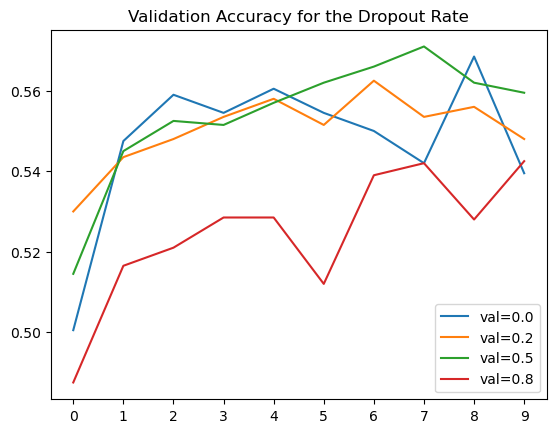

Epoch 1/10
250/250 [==============================] - 9s 28ms/step - loss: 1.8863 - accuracy: 0.4476 - val_loss: 1.6012 - val_accuracy: 0.5175
Epoch 2/10
250/250 [==============================] - 6s 25ms/step - loss: 1.4048 - accuracy: 0.5664 - val_loss: 1.4888 - val_accuracy: 0.5380
Epoch 3/10
250/250 [==============================] - 6s 24ms/step - loss: 1.2121 - accuracy: 0.6191 - val_loss: 1.4850 - val_accuracy: 0.5315
Epoch 4/10
250/250 [==============================] - 6s 25ms/step - loss: 1.0580 - accuracy: 0.6670 - val_loss: 1.4778 - val_accuracy: 0.5560
Epoch 5/10
250/250 [==============================] - 6s 24ms/step - loss: 0.8980 - accuracy: 0.7084 - val_loss: 1.5379 - val_accuracy: 0.5535
Epoch 6/10
250/250 [==============================] - 6s 24ms/step - loss: 0.7719 - accuracy: 0.7456 - val_loss: 1.5200 - val_accuracy: 0.5560
Epoch 7/10
250/250 [==============================] - 6s 24ms/step - loss: 0.6758 - accuracy: 0.7768 - val_loss: 1.5354 - val_accuracy: 0.5555

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

# Load the data
def load_data(folder):
    data = np.load(os.path.join(folder, 'data.npy'))
    labels = np.load(os.path.join(folder, 'labels.npy'))
    return data, labels

# Define the model
def make_model(learning_rate=0.01, size_inner=10, droprate=0.0):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(75, 75, 3)  # Use the resized image size 75x75
    )
    base_model.trainable = False
    inputs = keras.Input(shape=(75, 75, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    vectors = Dropout(droprate)(vectors)  # Add dropout
    vectors = keras.layers.Dense(size_inner, activation='relu')(vectors)  # Adjust the size of inner layer
    outputs = keras.layers.Dense(20)(vectors)  # Use 20 superclasses
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    return model

# Load the data
data_train, label_train = load_data('../data/clean-all-cifar-100-python/train')
data_test, label_test = load_data('../data/clean-all-cifar-100-python/validate')

# Fine-tune the learning rate
best_val_accuracy = 0
best_lr = 0
scores = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)
    model = make_model(learning_rate=lr)
    history = model.fit(data_train, label_train, epochs=10, validation_data=(data_test, label_test))
    scores[lr] = history.history
    if max(history.history['val_accuracy']) > best_val_accuracy:
        best_val_accuracy = max(history.history['val_accuracy'])
        best_lr = lr

for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))
plt.title('Validation Accuracy for the Learning Rate')
plt.xticks(np.arange(10))
plt.legend()
plt.show()

# Fine-tune the size_inner parameter
best_val_accuracy = 0
best_size = 0
scores = {}
for size in [10, 100, 1000]:
    print(size)
    model = make_model(learning_rate=best_lr, size_inner=size)
    history = model.fit(data_train, label_train, epochs=10, validation_data=(data_test, label_test))
    scores[size] = history.history
    if max(history.history['val_accuracy']) > best_val_accuracy:
        best_val_accuracy = max(history.history['val_accuracy'])
        best_size = size

for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))
plt.title('Validation Accuracy for the size_inner Parameter')
plt.xticks(np.arange(10))
plt.legend()
plt.show()
        
# Fine-tune the dropout rate
best_val_accuracy = 0
best_droprate = 0
scores = {}
for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)
    model = make_model(learning_rate=best_lr, size_inner=best_size, droprate=droprate)
    history = model.fit(data_train, label_train, epochs=10, validation_data=(data_test, label_test))
    scores[droprate] = history.history
    if max(history.history['val_accuracy']) > best_val_accuracy:
        best_val_accuracy = max(history.history['val_accuracy'])
        best_droprate = droprate

for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))
plt.title('Validation Accuracy for the Dropout Rate')
plt.xticks(np.arange(10))
plt.legend()
plt.show()
        
# Save the best model using callbacks and checkpointing
model = make_model(learning_rate=best_lr, size_inner=best_size, droprate=best_droprate)
checkpoint = ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)
history = model.fit(
    data_train,
    label_train,
    epochs=10,
    validation_data=(data_test, label_test),
    callbacks=[checkpoint]
)

### B) Model Architecture: ResNet50

0.0001
Epoch 1/10
250/250 [==============================] - 10s 31ms/step - loss: 3.0002 - accuracy: 0.0684 - val_loss: 2.9984 - val_accuracy: 0.0710
Epoch 2/10
250/250 [==============================] - 6s 24ms/step - loss: 2.9943 - accuracy: 0.0632 - val_loss: 2.9965 - val_accuracy: 0.0695
Epoch 3/10
250/250 [==============================] - 6s 24ms/step - loss: 2.9932 - accuracy: 0.0763 - val_loss: 2.9949 - val_accuracy: 0.0535
Epoch 4/10
250/250 [==============================] - 6s 24ms/step - loss: 2.9919 - accuracy: 0.0714 - val_loss: 2.9958 - val_accuracy: 0.0690
Epoch 5/10
250/250 [==============================] - 6s 24ms/step - loss: 2.9909 - accuracy: 0.0786 - val_loss: 2.9942 - val_accuracy: 0.0705
Epoch 6/10
250/250 [==============================] - 6s 24ms/step - loss: 2.9897 - accuracy: 0.0781 - val_loss: 2.9931 - val_accuracy: 0.0615
Epoch 7/10
250/250 [==============================] - 6s 24ms/step - loss: 2.9879 - accuracy: 0.0779 - val_loss: 2.9919 - val_accuracy

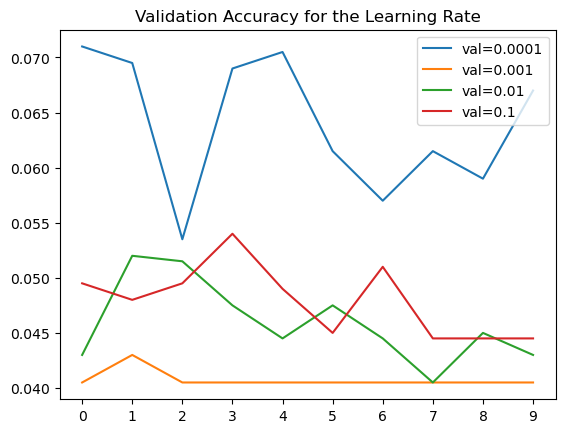

10
Epoch 1/10
250/250 [==============================] - 9s 29ms/step - loss: 3.0062 - accuracy: 0.0472 - val_loss: 2.9939 - val_accuracy: 0.0650
Epoch 2/10
250/250 [==============================] - 6s 25ms/step - loss: 2.9912 - accuracy: 0.0671 - val_loss: 2.9910 - val_accuracy: 0.0640
Epoch 3/10
250/250 [==============================] - 6s 25ms/step - loss: 2.9878 - accuracy: 0.0719 - val_loss: 2.9884 - val_accuracy: 0.0690
Epoch 4/10
250/250 [==============================] - 6s 25ms/step - loss: 2.9847 - accuracy: 0.0710 - val_loss: 2.9862 - val_accuracy: 0.0785
Epoch 5/10
250/250 [==============================] - 6s 25ms/step - loss: 2.9813 - accuracy: 0.0782 - val_loss: 2.9831 - val_accuracy: 0.0775
Epoch 6/10
250/250 [==============================] - 6s 25ms/step - loss: 2.9779 - accuracy: 0.0815 - val_loss: 2.9797 - val_accuracy: 0.0770
Epoch 7/10
250/250 [==============================] - 6s 25ms/step - loss: 2.9744 - accuracy: 0.0809 - val_loss: 2.9768 - val_accuracy: 0.0

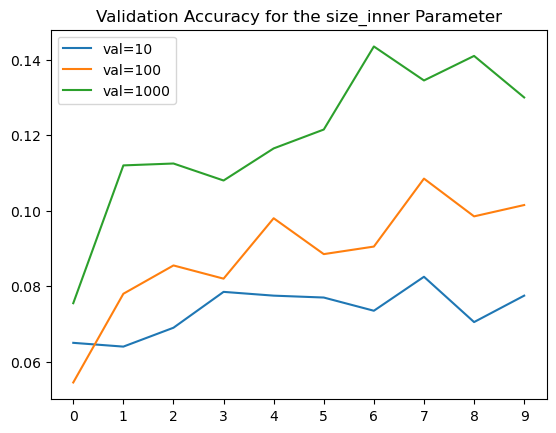

0.0
Epoch 1/10
250/250 [==============================] - 10s 29ms/step - loss: 2.9838 - accuracy: 0.0723 - val_loss: 2.9538 - val_accuracy: 0.0795
Epoch 2/10
250/250 [==============================] - 6s 25ms/step - loss: 2.9369 - accuracy: 0.1013 - val_loss: 2.9282 - val_accuracy: 0.0805
Epoch 3/10
250/250 [==============================] - 6s 25ms/step - loss: 2.9038 - accuracy: 0.1121 - val_loss: 2.9006 - val_accuracy: 0.1100
Epoch 4/10
250/250 [==============================] - 6s 25ms/step - loss: 2.8781 - accuracy: 0.1224 - val_loss: 2.8818 - val_accuracy: 0.1105
Epoch 5/10
250/250 [==============================] - 6s 25ms/step - loss: 2.8524 - accuracy: 0.1299 - val_loss: 2.8834 - val_accuracy: 0.1065
Epoch 6/10
250/250 [==============================] - 6s 25ms/step - loss: 2.8351 - accuracy: 0.1395 - val_loss: 2.8384 - val_accuracy: 0.1260
Epoch 7/10
250/250 [==============================] - 6s 25ms/step - loss: 2.8179 - accuracy: 0.1482 - val_loss: 2.8496 - val_accuracy: 0

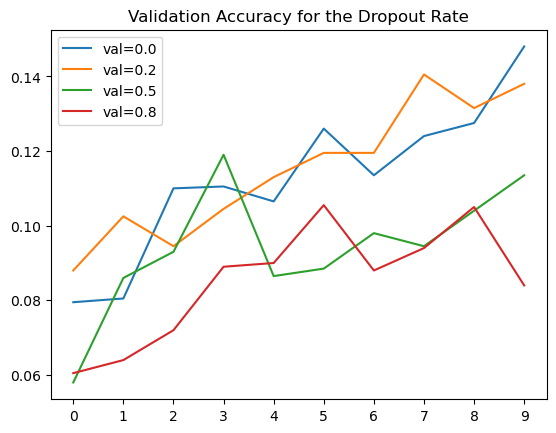

Epoch 1/10
250/250 [==============================] - 11s 31ms/step - loss: 2.9860 - accuracy: 0.0680 - val_loss: 2.9649 - val_accuracy: 0.0915
Epoch 2/10
250/250 [==============================] - 6s 25ms/step - loss: 2.9463 - accuracy: 0.0950 - val_loss: 2.9315 - val_accuracy: 0.0835
Epoch 3/10
250/250 [==============================] - 7s 26ms/step - loss: 2.9114 - accuracy: 0.1126 - val_loss: 2.9077 - val_accuracy: 0.1040
Epoch 4/10
250/250 [==============================] - 7s 26ms/step - loss: 2.8879 - accuracy: 0.1243 - val_loss: 2.8810 - val_accuracy: 0.1215
Epoch 5/10
250/250 [==============================] - 7s 26ms/step - loss: 2.8620 - accuracy: 0.1293 - val_loss: 2.8803 - val_accuracy: 0.1270
Epoch 6/10
250/250 [==============================] - 6s 25ms/step - loss: 2.8437 - accuracy: 0.1402 - val_loss: 2.8556 - val_accuracy: 0.1135
Epoch 7/10
250/250 [==============================] - 6s 25ms/step - loss: 2.8217 - accuracy: 0.1420 - val_loss: 2.8511 - val_accuracy: 0.122

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

# Load the data
def load_data(folder):
    data = np.load(os.path.join(folder, 'data.npy'))
    labels = np.load(os.path.join(folder, 'labels.npy'))
    return data, labels

# Define the model
def make_model(learning_rate=0.01, size_inner=10, droprate=0.0):
    base_model = ResNet50(  # Use ResNet50
        weights='imagenet',
        include_top=False,
        input_shape=(75, 75, 3)  # Use the resized image size 75x75
    )
    base_model.trainable = False
    inputs = keras.Input(shape=(75, 75, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    vectors = Dropout(droprate)(vectors)  # Add dropout
    vectors = keras.layers.Dense(size_inner, activation='relu')(vectors)  # Adjust the size of inner layer
    outputs = keras.layers.Dense(20)(vectors)  # Use 20 superclasses
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    return model

# Load the data
data_train, label_train = load_data('../data/clean-all-cifar-100-python/train')
data_test, label_test = load_data('../data/clean-all-cifar-100-python/validate')

# Fine-tune the learning rate
best_val_accuracy = 0
best_lr = 0
scores = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)
    model = make_model(learning_rate=lr)
    history = model.fit(data_train, label_train, epochs=10, validation_data=(data_test, label_test))
    scores[lr] = history.history
    if max(history.history['val_accuracy']) > best_val_accuracy:
        best_val_accuracy = max(history.history['val_accuracy'])
        best_lr = lr

for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))
plt.title('Validation Accuracy for the Learning Rate')
plt.xticks(np.arange(10))
plt.legend()
plt.show()

# Fine-tune the size_inner parameter
best_val_accuracy = 0
best_size = 0
scores = {}
for size in [10, 100, 1000]:
    print(size)
    model = make_model(learning_rate=best_lr, size_inner=size)
    history = model.fit(data_train, label_train, epochs=10, validation_data=(data_test, label_test))
    scores[size] = history.history
    if max(history.history['val_accuracy']) > best_val_accuracy:
        best_val_accuracy = max(history.history['val_accuracy'])
        best_size = size

for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))
plt.title('Validation Accuracy for the size_inner Parameter')
plt.xticks(np.arange(10))
plt.legend()
plt.show()
        
# Fine-tune the dropout rate
best_val_accuracy = 0
best_droprate = 0
scores = {}
for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)
    model = make_model(learning_rate=best_lr, size_inner=best_size, droprate=droprate)
    history = model.fit(data_train, label_train, epochs=10, validation_data=(data_test, label_test))
    scores[droprate] = history.history
    if max(history.history['val_accuracy']) > best_val_accuracy:
        best_val_accuracy = max(history.history['val_accuracy'])
        best_droprate = droprate

for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))
plt.title('Validation Accuracy for the Dropout Rate')
plt.xticks(np.arange(10))
plt.legend()
plt.show()

# Save the best model using callbacks and checkpointing
model = make_model(learning_rate=best_lr, size_inner=best_size, droprate=best_droprate)
checkpoint = ModelCheckpoint(
    'resnet50_v1_{epoch:02d}_{val_accuracy:.3f}.h5',  # Change the filename to reflect the use of ResNet50
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)
history = model.fit(
    data_train,
    label_train,
    epochs=10,
    validation_data=(data_test, label_test),
    callbacks=[checkpoint]
)

### C) Model Architecture: DenseNet121

0.0001
Epoch 1/50
250/250 [==============================] - 14s 32ms/step - loss: 3.1558 - accuracy: 0.0621 - val_loss: 3.0032 - val_accuracy: 0.0630
Epoch 2/50
250/250 [==============================] - 5s 22ms/step - loss: 2.9647 - accuracy: 0.0846 - val_loss: 2.9371 - val_accuracy: 0.0890
Epoch 3/50
250/250 [==============================] - 5s 22ms/step - loss: 2.8825 - accuracy: 0.1096 - val_loss: 2.8514 - val_accuracy: 0.1225
Epoch 4/50
250/250 [==============================] - 5s 22ms/step - loss: 2.7910 - accuracy: 0.1446 - val_loss: 2.7653 - val_accuracy: 0.1690
Epoch 5/50
250/250 [==============================] - 6s 22ms/step - loss: 2.6928 - accuracy: 0.1789 - val_loss: 2.6744 - val_accuracy: 0.1900
Epoch 6/50
250/250 [==============================] - 5s 22ms/step - loss: 2.5920 - accuracy: 0.2076 - val_loss: 2.5849 - val_accuracy: 0.2205
Epoch 7/50
250/250 [==============================] - 6s 22ms/step - loss: 2.4964 - accuracy: 0.2407 - val_loss: 2.4935 - val_accuracy

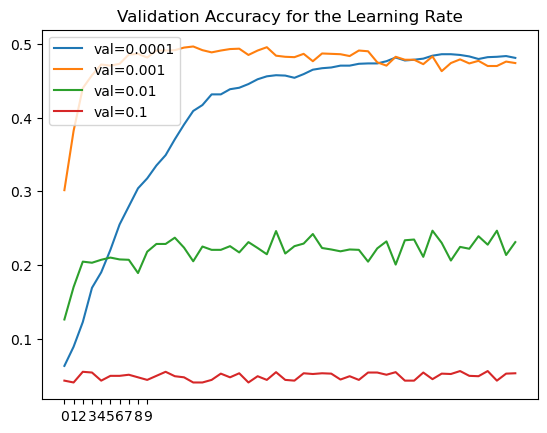

10
Epoch 1/50
250/250 [==============================] - 12s 30ms/step - loss: 2.7225 - accuracy: 0.1793 - val_loss: 2.4600 - val_accuracy: 0.2335
Epoch 2/50
250/250 [==============================] - 5s 22ms/step - loss: 2.2229 - accuracy: 0.3162 - val_loss: 2.0683 - val_accuracy: 0.3605
Epoch 3/50
250/250 [==============================] - 5s 22ms/step - loss: 1.8784 - accuracy: 0.4074 - val_loss: 1.8750 - val_accuracy: 0.4140
Epoch 4/50
250/250 [==============================] - 5s 22ms/step - loss: 1.6721 - accuracy: 0.4723 - val_loss: 1.7869 - val_accuracy: 0.4415
Epoch 5/50
250/250 [==============================] - 5s 22ms/step - loss: 1.5630 - accuracy: 0.5042 - val_loss: 1.7331 - val_accuracy: 0.4625
Epoch 6/50
250/250 [==============================] - 5s 22ms/step - loss: 1.4907 - accuracy: 0.5251 - val_loss: 1.6940 - val_accuracy: 0.4735
Epoch 7/50
250/250 [==============================] - 6s 22ms/step - loss: 1.4400 - accuracy: 0.5396 - val_loss: 1.6800 - val_accuracy: 0.

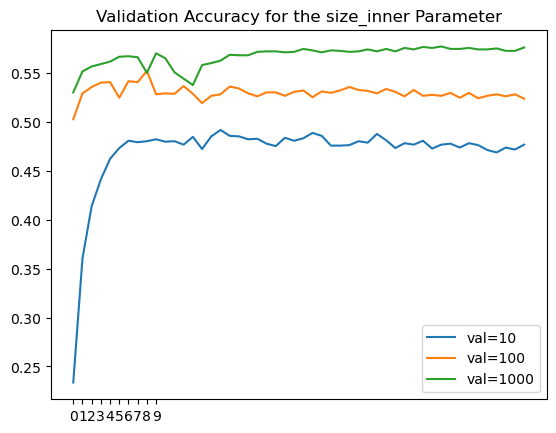

0.0
Epoch 1/50
250/250 [==============================] - 12s 28ms/step - loss: 1.7934 - accuracy: 0.4773 - val_loss: 1.4988 - val_accuracy: 0.5220
Epoch 2/50
250/250 [==============================] - 5s 21ms/step - loss: 1.1308 - accuracy: 0.6382 - val_loss: 1.4837 - val_accuracy: 0.5450
Epoch 3/50
250/250 [==============================] - 5s 21ms/step - loss: 0.8283 - accuracy: 0.7334 - val_loss: 1.4935 - val_accuracy: 0.5550
Epoch 4/50
250/250 [==============================] - 5s 21ms/step - loss: 0.6001 - accuracy: 0.8105 - val_loss: 1.5709 - val_accuracy: 0.5515
Epoch 5/50
250/250 [==============================] - 5s 21ms/step - loss: 0.4048 - accuracy: 0.8814 - val_loss: 1.6687 - val_accuracy: 0.5575
Epoch 6/50
250/250 [==============================] - 5s 21ms/step - loss: 0.2528 - accuracy: 0.9324 - val_loss: 1.8490 - val_accuracy: 0.5570
Epoch 7/50
250/250 [==============================] - 5s 21ms/step - loss: 0.1584 - accuracy: 0.9647 - val_loss: 1.9858 - val_accuracy: 0

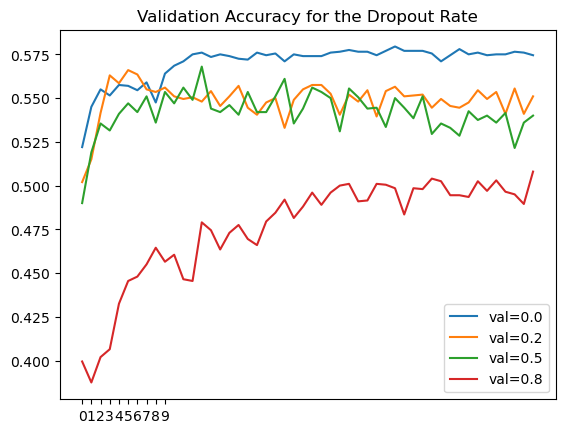

Epoch 1/50
250/250 [==============================] - 12s 31ms/step - loss: 1.7944 - accuracy: 0.4692 - val_loss: 1.5739 - val_accuracy: 0.5100
Epoch 2/50
250/250 [==============================] - 7s 26ms/step - loss: 1.1420 - accuracy: 0.6395 - val_loss: 1.4722 - val_accuracy: 0.5435
Epoch 3/50
250/250 [==============================] - 6s 24ms/step - loss: 0.8467 - accuracy: 0.7280 - val_loss: 1.4883 - val_accuracy: 0.5565
Epoch 4/50
250/250 [==============================] - 5s 22ms/step - loss: 0.5904 - accuracy: 0.8135 - val_loss: 1.5718 - val_accuracy: 0.5505
Epoch 5/50
250/250 [==============================] - 5s 22ms/step - loss: 0.3998 - accuracy: 0.8814 - val_loss: 1.7441 - val_accuracy: 0.5465
Epoch 6/50
250/250 [==============================] - 6s 24ms/step - loss: 0.2506 - accuracy: 0.9333 - val_loss: 1.7559 - val_accuracy: 0.5655
Epoch 7/50
250/250 [==============================] - 6s 24ms/step - loss: 0.1523 - accuracy: 0.9654 - val_loss: 1.8204 - val_accuracy: 0.579

In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.densenet import DenseNet121 
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

# Load the data
def load_data(folder):
    data = np.load(os.path.join(folder, 'data.npy'))
    labels = np.load(os.path.join(folder, 'labels.npy'))
    return data, labels

# Define the model
def make_model(learning_rate=0.01, size_inner=10, droprate=0.0):
    base_model = DenseNet121(  # Use DenseNet121 instead of ResNet50
        weights='imagenet',
        include_top=False,
        input_shape=(75, 75, 3)  # Use the resized image size 75x75
    )
    base_model.trainable = False
    inputs = keras.Input(shape=(75, 75, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    vectors = Dropout(droprate)(vectors)  # Add dropout
    vectors = keras.layers.Dense(size_inner, activation='relu')(vectors)  # Adjust the size of inner layer
    outputs = keras.layers.Dense(20)(vectors)  # Use 20 superclasses
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    return model

# Load the data
data_train, label_train = load_data('../data/clean-all-cifar-100-python/train')
data_test, label_test = load_data('../data/clean-all-cifar-100-python/validate')

# Fine-tune the learning rate
best_val_accuracy = 0
best_lr = 0
scores = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)
    model = make_model(learning_rate=lr)
    history = model.fit(data_train, label_train, epochs=50, validation_data=(data_test, label_test))
    scores[lr] = history.history
    if max(history.history['val_accuracy']) > best_val_accuracy:
        best_val_accuracy = max(history.history['val_accuracy'])
        best_lr = lr

for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))
plt.title('Validation Accuracy for the Learning Rate')
plt.xticks(np.arange(10))
plt.legend()
plt.show()

# Fine-tune the size_inner parameter
best_val_accuracy = 0
best_size = 0
scores = {}
for size in [10, 100, 1000]:
    print(size)
    model = make_model(learning_rate=best_lr, size_inner=size)
    history = model.fit(data_train, label_train, epochs=50, validation_data=(data_test, label_test))
    scores[size] = history.history
    if max(history.history['val_accuracy']) > best_val_accuracy:
        best_val_accuracy = max(history.history['val_accuracy'])
        best_size = size

for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))
plt.title('Validation Accuracy for the size_inner Parameter')
plt.xticks(np.arange(10))
plt.legend()
plt.show()
        
# Fine-tune the dropout rate
best_val_accuracy = 0
best_droprate = 0
scores = {}
for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)
    model = make_model(learning_rate=best_lr, size_inner=best_size, droprate=droprate)
    history = model.fit(data_train, label_train, epochs=50, validation_data=(data_test, label_test))
    scores[droprate] = history.history
    if max(history.history['val_accuracy']) > best_val_accuracy:
        best_val_accuracy = max(history.history['val_accuracy'])
        best_droprate = droprate

for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))
plt.title('Validation Accuracy for the Dropout Rate')
plt.xticks(np.arange(10))
plt.legend()
plt.show()

# Save the best model using callbacks and checkpointing
model = make_model(learning_rate=best_lr, size_inner=best_size, droprate=best_droprate)
checkpoint = ModelCheckpoint(
    'densenet121_v1_{epoch:02d}_{val_accuracy:.3f}.h5',  # Change the filename to reflect the use of DenseNet121
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)
history = model.fit(
    data_train,
    label_train,
    epochs=50,
    validation_data=(data_test, label_test),
    callbacks=[checkpoint]
)

### D) Best Model Comparison

63/63 [==============================] - 2s 18ms/step


/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


63/63 [==============================] - 3s 16ms/step


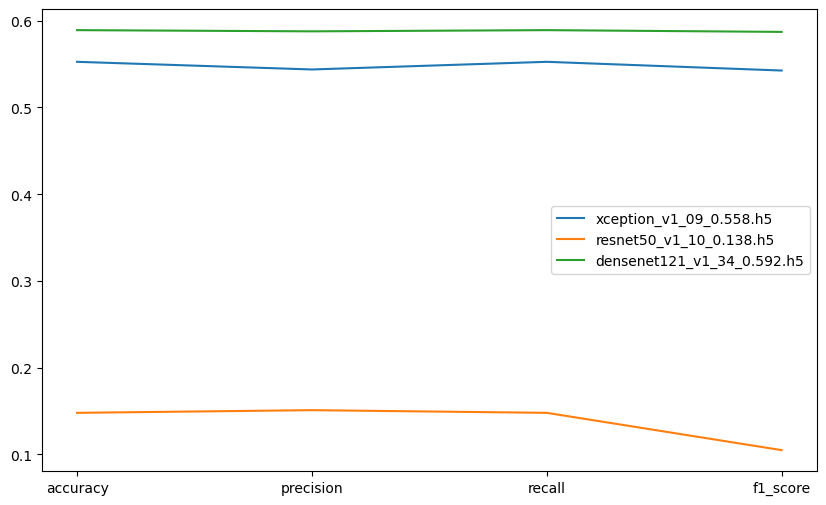

In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Load the data
def load_data(folder):
    data = np.load(os.path.join(folder, 'data.npy'))
    labels = np.load(os.path.join(folder, 'labels.npy'))
    return data, labels

# Load the test data
data_test, label_test = load_data('../data/clean-all-cifar-100-python/test')

# Define the model names
model_names = ['xception_v1_09_0.558.h5', 
               'resnet50_v1_10_0.138.h5', 
               'densenet121_v1_34_0.592.h5']

# Initialize a dictionary to store the metrics
metrics = {}

# For each model
for model_name in model_names:
    # Load the model
    model = load_model(model_name)
    # Evaluate the model
    loss, accuracy = model.evaluate(data_test, label_test, verbose=0)
    # Predict the classes
    y_pred = model.predict(data_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(label_test, axis=1)
    # Calculate precision, recall, and F1 score
    classification_metrics = classification_report(y_true_classes, y_pred_classes, output_dict=True)
    precision = classification_metrics['weighted avg']['precision']
    recall = classification_metrics['weighted avg']['recall']
    f1_score = classification_metrics['weighted avg']['f1-score']
    # Store the metrics
    metrics[model_name] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1_score}

# Plot the metrics
plt.figure(figsize=(10, 6))
for model_name, model_metrics in metrics.items():
    plt.plot(list(model_metrics.values()), label=model_name)
plt.xticks(np.arange(4), ['accuracy', 'precision', 'recall', 'f1_score'])
plt.legend()
plt.show()

### E) Final Model Selection

In [9]:
# The name of the best model based on the Best Model Comparison
print("densenet121_v1_34_0.592.h5")

densenet121_v1_34_0.592.h5
